   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 12.7 MB/s eta 0:00:00:00:0100:01
Running on cpu
Synthetic dataset generated: (4200, 10)


,timestamp,building,distance,ambient_temp,chws_temp,chwr_temp,flow_rate,tr_load,cooling_kw,electrical_kw
0,0,MMR-C4,Near,28.825978,5.062579,15.194552,385.081040,1036.681694,36.460095,10.313591
1,1,MMR-C4,Near,30.755969,5.064926,15.101957,275.114006,740.879998,26.056750,8.544922
2,2,MMR-C4,Near,30.671801,5.074903,14.711532,268.721093,151.372144,5.323758,1.471486


100%|██████████| 300/300 [00:01<00:00, 180.40it/s]


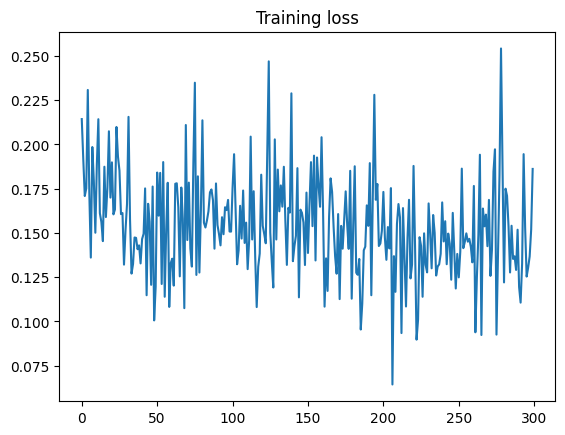

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://171ead6b0e1e997ff6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:


!pip install -q torch tqdm pandas scikit-learn matplotlib gradio

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple
import gradio as gr

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

# ==========================================
# 1️⃣ Synthetic Dataset (based on your schema)
# ==========================================
buildings = ["MMR-C4","GIFT-ONE","GIFT-TWO","Prestige Fintech",
             "Brigade Hotel","BSE","DC Plant","WTC (1)","WTC (2)",
             "Tata Data Centre","GIFT House","Hiranandani Sig.",
             "Brigade Com","Savvy (Pragya-I)"]
distance_categories = ["Near","Mid","Far"]

def generate_synthetic_data(n_points=300):
    rows = []
    for b in buildings:
        dist = random.choice(distance_categories)
        ambient_base = {"Near":30,"Mid":32,"Far":34}[dist]
        for t in range(n_points):
            ambient = ambient_base + np.random.normal(0,0.8)
            chws_temp = 5.0 + np.random.normal(0,0.05)
            chwr_temp = 15.0 + np.random.normal(0,0.2)
            flow_rate = np.random.uniform(100,400)
            tr_load = np.random.uniform(100,2200)
            cooling_kw = tr_load * 3.517 / 100
            electrical_kw = cooling_kw / np.random.uniform(3.0,4.0)
            rows.append({
                "timestamp": t,
                "building": b,
                "distance": dist,
                "ambient_temp": ambient,
                "chws_temp": chws_temp,
                "chwr_temp": chwr_temp,
                "flow_rate": flow_rate,
                "tr_load": tr_load,
                "cooling_kw": cooling_kw,
                "electrical_kw": electrical_kw
            })
    return pd.DataFrame(rows)

df = generate_synthetic_data()
print("Synthetic dataset generated:", df.shape)
display(df.head(3))


obs_cols = ['ambient_temp','chws_temp','chwr_temp',
            'flow_rate','tr_load','cooling_kw','electrical_kw']
act_cols = ['chws_temp']
reward_col = 'electrical_kw'


df = df.dropna()
df = df[df['electrical_kw'] > 0]


df['ambient_temp'] = df['ambient_temp'].rolling(window=3, min_periods=1).mean()

scaler = StandardScaler()
df[obs_cols] = scaler.fit_transform(df[obs_cols])


Transition = namedtuple("Transition", ("obs","action","reward","next_obs","done"))

class SyntheticChillerEnv:
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.t = 0
        self.max_t = len(df)-1
    def reset(self):
        self.t = 0
        return self.df.loc[self.t, obs_cols].values.astype(np.float32)
    def step(self, action):
        reward = -(self.df.loc[self.t, 'electrical_kw'] + 0.01*self.df.loc[self.t, 'tr_load'])
        done = (self.t >= self.max_t-1)
        self.t += 1
        next_obs = self.df.loc[self.t, obs_cols].values.astype(np.float32)
        return next_obs, reward, done, {}

env = SyntheticChillerEnv(df)


class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def push(self,*args): self.buffer.append(Transition(*args))
    def sample_mc(self,batch_size,horizon):
        idxs = np.random.randint(0, len(self.buffer)-horizon, size=batch_size)
        obs_b, act_b, e_tgts = [],[],[]
        for i in idxs:
            avg_e = np.mean([-self.buffer[j].reward for j in range(i, i+horizon)])
            obs_b.append(self.buffer[i].obs)
            act_b.append(self.buffer[i].action)
            e_tgts.append(avg_e)
        return np.array(obs_b), np.array(act_b), np.array(e_tgts)

buffer = ReplayBuffer()
obs = env.reset()
for _ in range(1000):
    a = np.random.uniform(-1,1,len(act_cols))
    nxt,r,d,_ = env.step(a)
    buffer.push(obs,a,r,nxt,d)
    obs = nxt

class QNet(nn.Module):
    def __init__(self):
        super().__init__()
        hidden=128
        self.net=nn.Sequential(
            nn.Linear(len(obs_cols)+len(act_cols), hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden,1)
        )
    def forward(self,obs,act):
        x=torch.cat([obs,act],dim=-1)
        return self.net(x).squeeze(-1)

class Ensemble:
    def __init__(self,n=3):
        self.models=[QNet().to(DEVICE) for _ in range(n)]
        self.opts=[optim.Adam(m.parameters(),lr=1e-3) for m in self.models]
    def predict(self,obs,act):
        obs_t=torch.tensor(obs,dtype=torch.float32,device=DEVICE)
        act_t=torch.tensor(act,dtype=torch.float32,device=DEVICE)
        preds=[]
        for m in self.models:
            with torch.no_grad():
                preds.append(m(obs_t,act_t).cpu().numpy())
        preds=np.stack(preds)
        return preds.mean(0), preds.std(0)
    def train_step(self,obs,act,e_tgt):
        obs_t=torch.tensor(obs,dtype=torch.float32,device=DEVICE)
        act_t=torch.tensor(act,dtype=torch.float32,device=DEVICE)
        y_t=torch.tensor(e_tgt,dtype=torch.float32,device=DEVICE)
        losses=[]
        for m,opt in zip(self.models,self.opts):
            opt.zero_grad()
            pred=m(obs_t,act_t)
            loss=((pred-y_t)**2).mean()
            loss.backward(); opt.step()
            losses.append(loss.item())
        return np.mean(losses)


ensemble=Ensemble()
HORIZON=5; BATCH=64; ITER=300
losses=[]
for it in trange(ITER):
    obs_b,act_b,e_t=buffer.sample_mc(BATCH,HORIZON)
    l=ensemble.train_step(obs_b,act_b,e_t)
    losses.append(l)
plt.plot(losses); plt.title("Training loss"); plt.show()


class Controller:
    def __init__(self,model): self.model=model
    def select_action(self,obs):
        obs=np.array(obs).reshape(1,-1)
        cand=np.random.uniform(-1,1,(500,len(act_cols)))
        obs_rep=np.repeat(obs,len(cand),axis=0)
        mean,std=self.model.predict(obs_rep,cand)
        score=mean+0.5*std
        return cand[np.argmin(score)]

controller=Controller(ensemble)

def predict_chws_temp(tr_load, ambient_temp, electricity_kw):
    obs=np.zeros(len(obs_cols))
    obs[obs_cols.index('tr_load')] = (tr_load - df['tr_load'].mean()) / df['tr_load'].std()
    obs[obs_cols.index('ambient_temp')] = (ambient_temp - df['ambient_temp'].mean()) / df['ambient_temp'].std()
    obs[obs_cols.index('cooling_kw')] = (tr_load * 3.517 / 100 - df['cooling_kw'].mean()) / df['cooling_kw'].std()
    obs[obs_cols.index('electrical_kw')] = (electricity_kw - df['electrical_kw'].mean()) / df['electrical_kw'].std()
    obs[obs_cols.index('chwr_temp')] = (15 - df['chwr_temp'].mean()) / df['chwr_temp'].std()
    obs[obs_cols.index('flow_rate')] = (250 - df['flow_rate'].mean()) / df['flow_rate'].std()
    obs[obs_cols.index('chws_temp')] = (5.0 - df['chws_temp'].mean()) / df['chws_temp'].std()

    
    best_action=controller.select_action(obs)
    ai_chws=8+best_action[0]*4.0
    ai_chws=np.clip(ai_chws,4.0,12.0)

   
    heuristic=10 - 0.002*tr_load - 0.05*(ambient_temp-25)


    final_chws=0.7*ai_chws + 0.3*heuristic
    final_chws=np.clip(final_chws,4.0,12.0)

    return round(float(final_chws),2)

iface=gr.Interface(
    fn=predict_chws_temp,
    inputs=[
        gr.Number(label="TR Load (TR)", value=1500),
        gr.Number(label="Ambient Temperature (°C)", value=30),
        gr.Number(label="Electricity Consumed (kW)", value=1000)
    ],
    outputs=gr.Number(label="Recommended CHWS Temp (°C)"),
    title="Hybrid AI Chiller Controller",
    description="Enter TR load, ambient temperature, and electricity use → Get AI+physics recommended chilled water temperature."
)

iface.launch(share=True)
